## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

## Load and preprocess the dataset

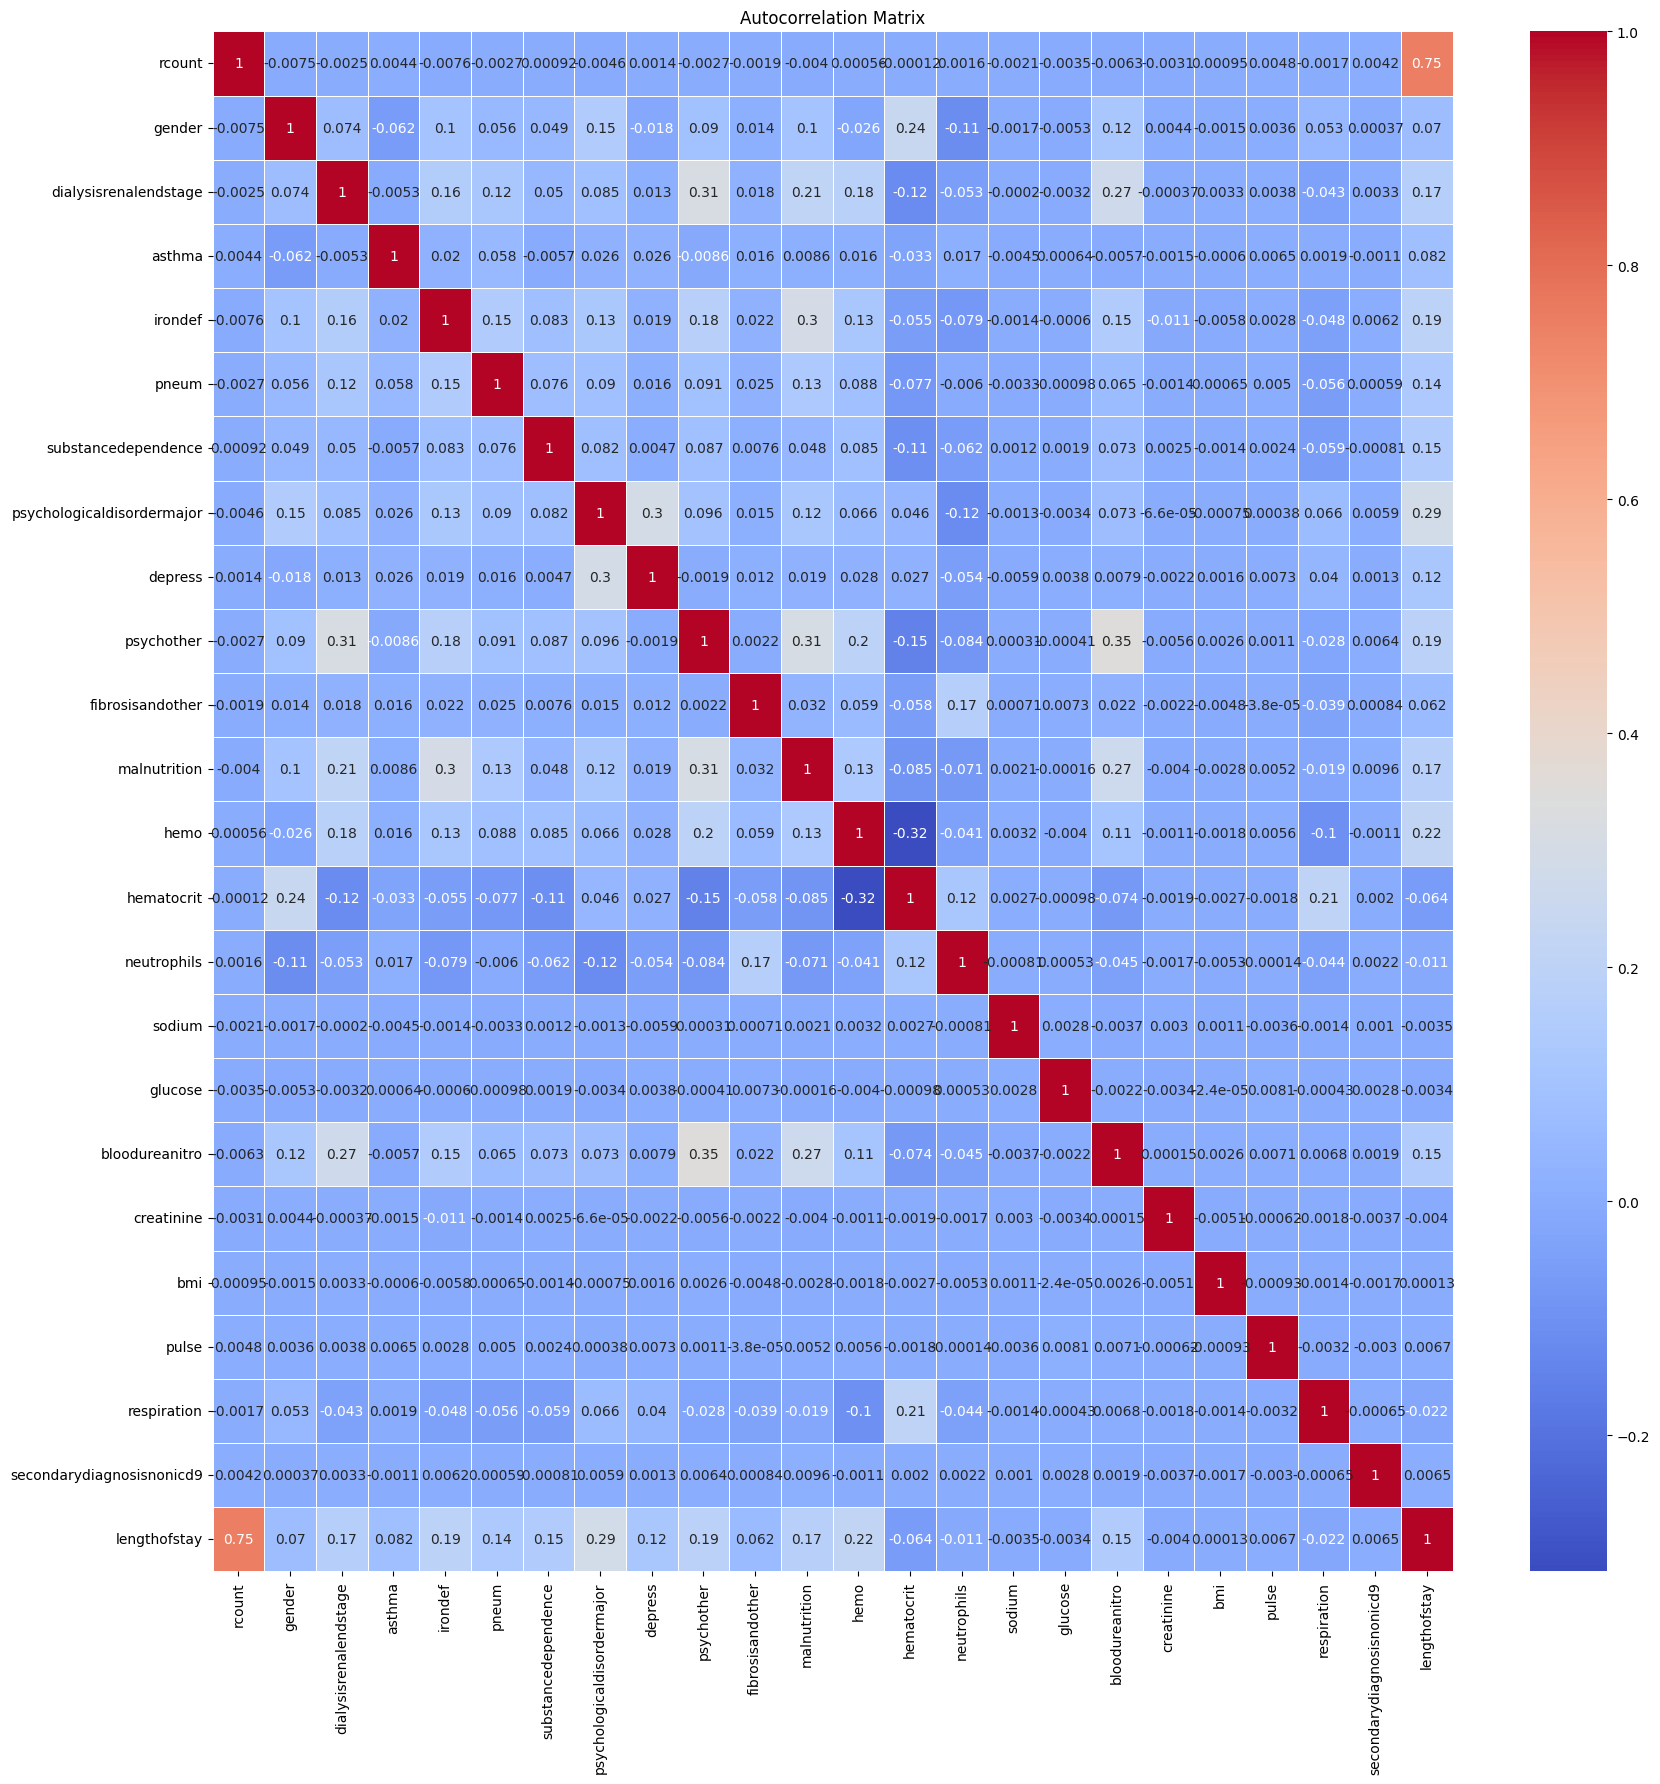

In [2]:
data = pd.read_csv("LengthOfStay.csv")

data = data.drop(columns=["eid", "vdate", "discharged", "facid"])

data["rcount"] = data["rcount"].replace("5+", 5).apply(pd.to_numeric, errors='coerce')

categorical_cols = ["gender", "dialysisrenalendstage", "asthma", "irondef", "pneum", "substancedependence",
                    "psychologicaldisordermajor", "depress", "psychother", "fibrosisandother", "malnutrition", "hemo",
                    "secondarydiagnosisnonicd9"]
data["gender"] = data["gender"].map({"F": 0, "M": 1})

autocorr_matrix = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(autocorr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Autocorrelation Matrix")
plt.show()

X = data.drop(columns=["lengthofstay"])
y = data["lengthofstay"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = tf.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Build the LSTM model

In [3]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

## Train the model

In [4]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
2000/2000 [==============================] - 9s 3ms/step - loss: 2.9734 - val_loss: 1.3338
Epoch 2/50
2000/2000 [==============================] - 5s 3ms/step - loss: 1.2129 - val_loss: 1.1725
Epoch 3/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.1046 - val_loss: 1.1746
Epoch 4/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.0583 - val_loss: 1.0646
Epoch 5/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.0326 - val_loss: 1.0569
Epoch 6/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.0019 - val_loss: 1.0192
Epoch 7/50
2000/2000 [==============================] - 6s 3ms/step - loss: 0.9852 - val_loss: 1.0842
Epoch 8/50
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9755 - val_loss: 0.9830
Epoch 9/50
2000/2000 [==============================] - 6s 3ms/step - loss: 0.9641 - val_loss: 0.9780
Epoch 10/50
2000/2000 [==============================] - 6s 3ms/step - loss: 0.945

## Evaluate the model

In [5]:
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error (MSE): {mse}")

predictions = model.predict(X_test)
predictions = [i[0] for i in predictions]
predictions = np.round(predictions)

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

mape = mean_absolute_percentage_error(y_test, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

r2 = r2_score(y_test, predictions)
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 0.7223119735717773
625/625 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 0.5752000212669373
Mean Absolute Percentage Error (MAPE): 18.821460008621216%
R^2 Score: 0.8526205411452497


## Calculate feature importance

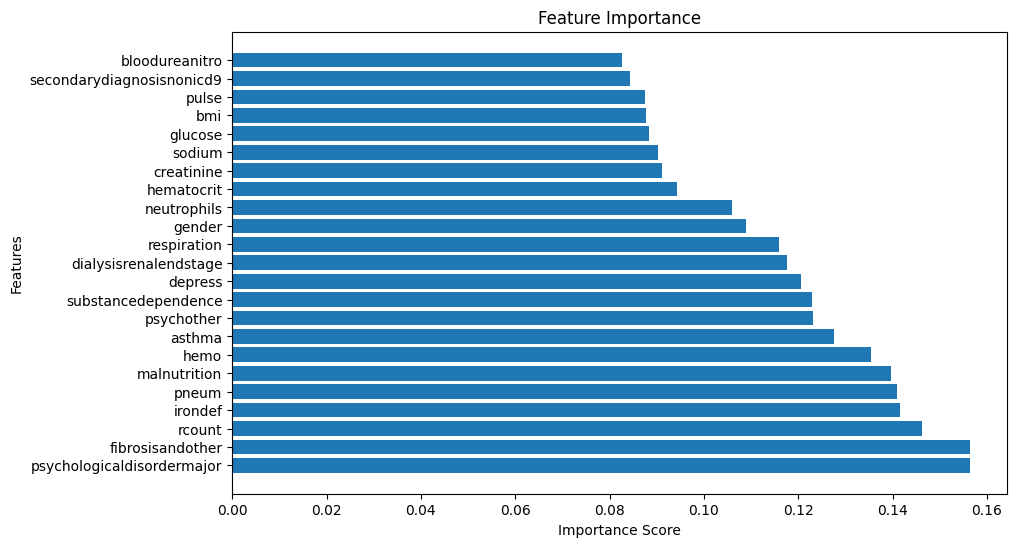

In [6]:
lstm_weights = model.layers[0].get_weights()[0]

importance_scores = np.mean(np.abs(lstm_weights), axis=1)
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_scores = importance_scores[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_scores, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

## Save the model

In [ ]:
model.save("model.h5")

## Example prediction

In [7]:
sample_index = 0
sample_length_of_stay = y_test[0:10]
sample_predicted_length_of_stay = predictions[0:10]
print(f"Sample Length of Stay: {sample_length_of_stay}")
print(f"Sample Predicted Length of Stay: {sample_predicted_length_of_stay}")

Sample Length of Stay: [4. 1. 2. 1. 5. 1. 2. 3. 4. 2.]
Sample Predicted Length of Stay: [3. 1. 2. 1. 6. 1. 2. 3. 5. 2.]


## Plot actual vs predicted values

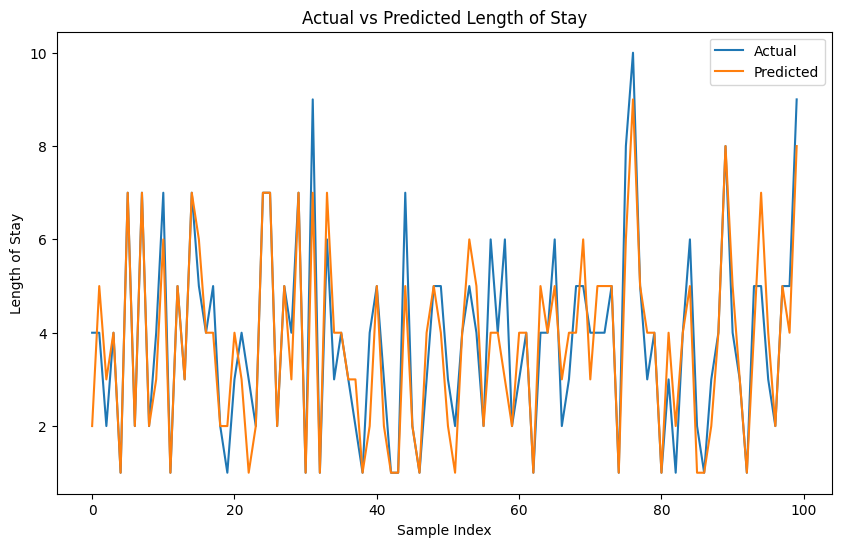

In [8]:
start_index = 100
end_index = 200

actual_lengths = y_test[start_index:end_index]
predicted_lengths = predictions[start_index:end_index]

plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_lengths)), actual_lengths, label='Actual')
plt.plot(range(len(predicted_lengths)), predicted_lengths, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Length of Stay')
plt.title('Actual vs Predicted Length of Stay')
plt.legend()
plt.show()

## Training model after deleting columns with the lowest feature importance

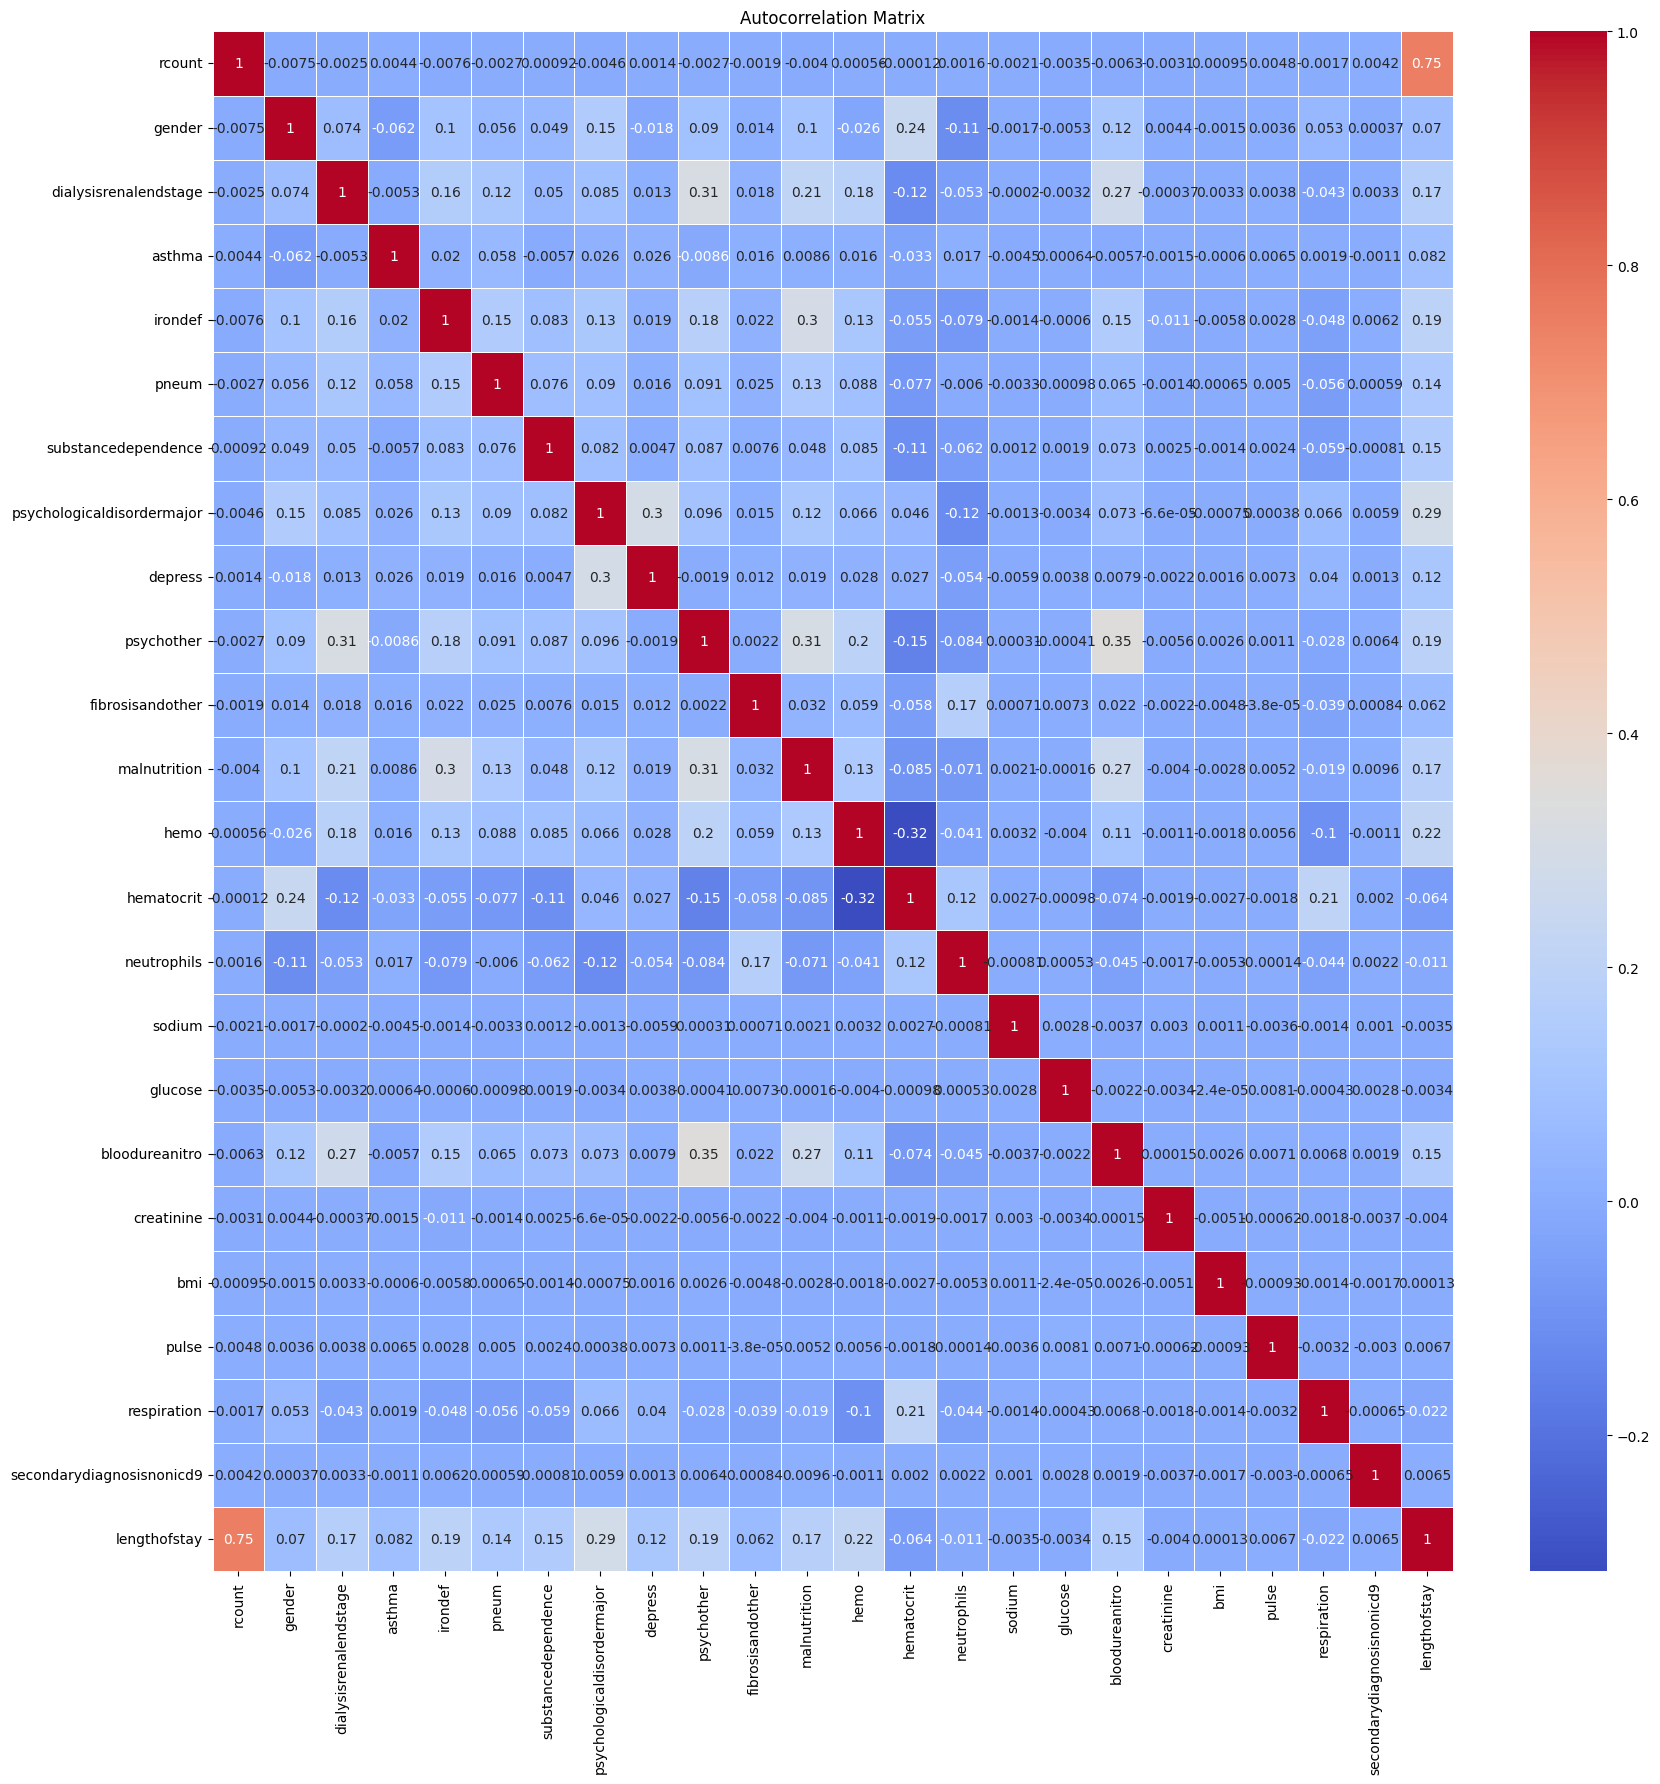

In [9]:
data = pd.read_csv("LengthOfStay.csv")

data = data.drop(columns=["eid", "vdate", "discharged", "facid"])

data["rcount"] = data["rcount"].replace("5+", 5).apply(pd.to_numeric, errors='coerce')

categorical_cols = ["gender", "dialysisrenalendstage", "asthma", "irondef", "pneum", "substancedependence",
                    "psychologicaldisordermajor", "depress", "psychother", "fibrosisandother", "malnutrition", "hemo",
                    "secondarydiagnosisnonicd9"]
data["gender"] = data["gender"].map({"F": 0, "M": 1})

autocorr_matrix = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(autocorr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Autocorrelation Matrix")
plt.show()

X = data.drop(columns=["lengthofstay", "glucose", "pulse", "secondarydiagnosisnonicd9", "bloodureanitro", "sodium", "bmi", "creatinine", "gender", "hematocrit", "respiration", "neutrophils"])
y = data["lengthofstay"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = tf.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [10]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
2000/2000 [==============================] - 8s 3ms/step - loss: 2.2771 - val_loss: 1.3228
Epoch 2/50
2000/2000 [==============================] - 7s 4ms/step - loss: 1.2659 - val_loss: 1.2904
Epoch 3/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.2464 - val_loss: 1.2759
Epoch 4/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.2341 - val_loss: 1.2697
Epoch 5/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.2239 - val_loss: 1.2591
Epoch 6/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.2160 - val_loss: 1.2512
Epoch 7/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.2095 - val_loss: 1.2513
Epoch 8/50
2000/2000 [==============================] - 7s 4ms/step - loss: 1.2039 - val_loss: 1.2399
Epoch 9/50
2000/2000 [==============================] - 5s 3ms/step - loss: 1.2008 - val_loss: 1.2358
Epoch 10/50
2000/2000 [==============================] - 6s 3ms/step - loss: 1.197

In [12]:
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error (MSE): {mse}")

predictions = model.predict(X_test)
predictions = [i[0] for i in predictions]
predictions = np.round(predictions)

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

mape = mean_absolute_percentage_error(y_test, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

r2 = r2_score(y_test, predictions)
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 1.1366798877716064
625/625 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 0.8568500280380249
Mean Absolute Percentage Error (MAPE): 33.55378806591034%
R^2 Score: 0.7795504360038967


In [13]:
sample_index = 0
sample_length_of_stay = y_test[0:10]
sample_predicted_length_of_stay = predictions[0:10]
print(f"Sample Length of Stay: {sample_length_of_stay}")
print(f"Sample Predicted Length of Stay: {sample_predicted_length_of_stay}")

Sample Length of Stay: [4. 1. 2. 1. 5. 1. 2. 3. 4. 2.]
Sample Predicted Length of Stay: [4. 2. 2. 2. 6. 2. 2. 2. 4. 3.]


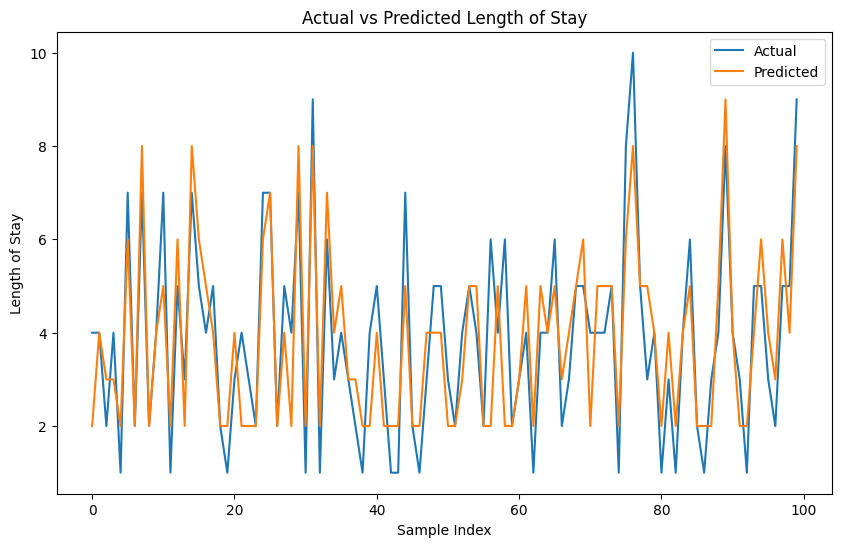

In [14]:
start_index = 100
end_index = 200

actual_lengths = y_test[start_index:end_index]
predicted_lengths = predictions[start_index:end_index]

plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_lengths)), actual_lengths, label='Actual')
plt.plot(range(len(predicted_lengths)), predicted_lengths, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Length of Stay')
plt.title('Actual vs Predicted Length of Stay')
plt.legend()
plt.show()